In [213]:
%matplotlib inline
from sklearn import datasets

In [214]:
import numpy as np
class Expert():

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    
    def sigmoid_derivativa(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    
    def tan_hiperbolica(self, x):
        #from https://alexander-wong.com/post/neural-networks-and-deep-learning-week3/
        return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

    
    def tan_hiperbolica_derivativa(self, x):
        #from https://alexander-wong.com/post/neural-networks-and-deep-learning-week3/
        return 1 - self.tan_hiperbolica(x)**2
    
    
    def softmax(self,x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    
    def softmax_derivativa(self,x):
        '''
        Retirada do codigo disponibilizado em aula ` dYdYin(:,cont)=(1-Y(:,i)).*Y(:,i);%sigmoid e softamax`
        '''
        return self.softmax(x) * (1 - self.softmax(x))
    
    
    def __init__(self,ne,nh,ns,g_h,g_o):
        '''
        ne = numero de neuronios entradas
        nh = numero neuronios hidden layer
        ns = numero de neuronios saida
        
        As funcoes de ativacao sao denotadas por
        g_h = funcao de ativacao camada escondida
        g_o = funcao de ativacao camada de saida
        
        e podem receber as seguintes entradas
        'sigmoid', 'tan_h', 'softmax' e 'linear'
        '''
        self.W1=np.random.uniform(size=(ne,nh))
        self.b1=np.random.uniform(size=(1,nh))
        self.W2=np.random.uniform(size=(nh,ns))
        self.b2=np.random.uniform(size=(1,ns))
        self.ghidden = g_h
        self.gout = g_o
        
        
    def executa_funcao_ativacao(self, tipo, x, derivativa=False):
        if tipo == 'sigmoid':
            if derivativa:
                return self.sigmoid_derivativa(x)
            else:
                return self.sigmoid(x)
        elif tipo == 'tan_h':
            if derivativa:
                return self.tan_hiperbolica_derivativa(x)
            else:
                return self.tan_hiperbolica(x)
        elif tipo == 'softmax':
            if derivativa:
                return self.softmax_derivativa(x)
            else:
                return self.softmax(x)
        elif tipo == 'linear':
            if derivativa:
                return np.ones(x.shape)
            else:
                return x
    
    
    def calcula_loss(self,erro_epoca):
        '''
        Calcula EQM
        '''
        loss = np.square(erro_epoca).mean()
        return loss
            
            
    def feedforward(self, X):
        #Forward Propogation
        #entrada -> hidden
        z1 = np.dot(X,self.W1) + self.b1
        a1 = self.executa_funcao_ativacao(self.ghidden, z1)
        #hidden -> saida
        z2=np.dot(a1,self.W2)+ self.b2
        output = self.executa_funcao_ativacao(self.gout, z2)
        return z1,a1,z2,output
    
    
    def backpropagation(self, X,y,z1,a1,z2,output,alpha):
        #Calcula deltas por partes
        erro_epoca = output - y
        delta_output = self.executa_funcao_ativacao(self.gout, output, derivativa=True)
        d_z2 = erro_epoca * delta_output
        erro_hidden = d_z2.dot(self.W2.T) * (1/len(X))
        delta_hidden = self.executa_funcao_ativacao(self.ghidden,z1,derivativa=True)
        d_z1 = erro_hidden * delta_hidden * (1/len(X))
        
        #Atualiza pesos
        self.W2 -= z1.T.dot(d_z2) * alpha
        self.b2 -= np.sum(d_z2, axis=0,keepdims=True) * alpha
        self.W1 -= X.T.dot(d_z1) * alpha
        self.b1 -= np.sum(d_z1, axis=0,keepdims=True) * alpha
        return erro_epoca
    

    def train(self, max_epoch, alpha, X, y, X_val, y_val, numero_max_erro_val=10, plot=False):
        #Variaveis de controle
        all_losses = [] #para plot
        numero_erro_validacao_subiu = 0 #acompanhamento do erro de validacao
        last_eqm_val = 99999  #acompanhamento do erro de validacao

        #armazena melhores pesos para retorno posterior
        melhores_pesos = {
            'W1' : self.W1,
            'b1' : self.b1,
            'W2' : self.W2,
            'b2' : self.b2
        }
        #Itera sobre as epocas
        for epoch in range(1,max_epoch+1):
            #feedforward
            z1,a1,z2,output = self.feedforward(X)
            #backward
            erro_epoca = self.backpropagation(X,y,z1,a1,z2,output,alpha)
            #gera loss
            all_losses.append(self.calcula_loss(erro_epoca))
            
            #calculo para acompanhar erro no conjunto de validacao
            z1_val,a1_val,z2_val,output_val = self.feedforward(X_val)
            #calcula erro de validacao
            erro_validacao = output_val - y_val
            eqm_validacao = self.calcula_loss(erro_validacao)
            
            #Acompanhamento eveolucao do erro no conjunto de validacao
            if eqm_validacao < last_eqm_val:
                numero_erro_validacao_subiu = 0
                last_eqm_val = eqm_validacao
                #Atualiza melhores pesos
                melhores_pesos = {
                    'W1' : self.W1,
                    'b1' : self.b1,
                    'W2' : self.W2,
                    'b2' : self.b2
                }
            else:
                last_eqm_val = eqm_validacao
                numero_erro_validacao_subiu += 1
                if numero_erro_validacao_subiu >= numero_max_erro_val:
                    print("Treinamento encerrado por aumentos consecutivos no erro de validacao, epocas {}".format(epoch))
                    #retorna os melhores pesos
                    self.W1 = melhores_pesos['W1']
                    self.b1 = melhores_pesos['b1']
                    self.W2 = melhores_pesos['W2']
                    self.b2 = melhores_pesos['b2']
                    if plot:       
                        #Se deseja plotar a evolucao do erro
                        import matplotlib.pyplot as plt
                        plt.plot(all_losses)
                        plt.show()
                    return melhores_pesos,all_losses
            
        print("Treinamento encerrado em {} epocas".format(epoch))
        if plot:       
            import matplotlib.pyplot as plt
            plt.plot(all_losses)
            plt.show()
        return melhores_pesos,all_losses

    def predict(self,X,melhores_pesos):
        #Retorna melhores pesos
        self.W1 = melhores_pesos['W1']
        self.b1 = melhores_pesos['b1']
        self.W2 = melhores_pesos['W2']
        self.b2 = melhores_pesos['b2']
        z1,a1,z2,output = self.feedforward(X)
        return output

        

In [215]:
from importlib import reload
import utils
reload(utils)

<module 'utils' from '/home/fernando.favoretti/src/personal/mixture_of_experts/utils.py'>

In [216]:
X, y = datasets.make_moons(100, noise=0.10)
X_train,y_train,X_test,y_test,X_val,y_val = utils.treino_teste_validacao(X,y, 0.5, 0.3)

Tamanho total 100
Tamanho treino 50
Tamanho teste 30
Tamanho validacao 20


In [219]:
#Variable initialization
max_epocas=1000
alpha=0.1 #Setting learning rate
ne = X.shape[1] #numero de features no dataset
nh = 3 #numero neuronios hidden
ns = 2 #numero neuronios saida
ep =Expert(ne,nh,ns,g_h='sigmoid',g_o='softmax')

Treinamento encerrado em 1000 epocas


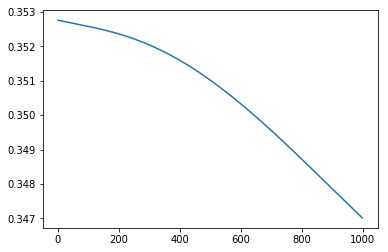

In [220]:
melhores_pesos,all_losses = ep.train(max_epocas, alpha, X_train, y_train, X_val, y_val, 5, plot=True)